0) Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
pd.set_option("display.precision", 3)
InteractiveShell.ast_node_interactivity = "all"
import pickle
import os

# Extra imports
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

def multiclass_confusion(y_pred, y_true):
    ### Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    ## Get Class Labels
    labels = set(y_true)
    class_names = sorted(labels)

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)
    plt.show()

In [2]:
def prepare_data(dataframe, variables, model_alignement, num_scaling = True):
    x = dataframe.loc[:, dataframe.columns != 'SUSPECT_RACE_DESCRIPTION']
    y = dataframe.loc[:, 'SUSPECT_RACE_DESCRIPTION']

    X = x.loc[:,variables]
    X = pd.get_dummies(X)

    alig, X = model_alignement.align(X, join='left', axis=1, fill_value=0)
    
    numericals = []
    for idx, types in enumerate(X.dtypes):
        if types == 'int64':
            numericals.append(X.columns[idx])
    if num_scaling:
        ct = ColumnTransformer([
                ('somename', StandardScaler(), numericals)
            ], remainder='passthrough')

        ct.fit_transform(X)
    return X, y

In [3]:
local_dir = os.getcwd()
#data_path = COSTUM_DATA_LOCATION
#model_path = COSTUM_MODEL_LOCATION
data_path = os.path.join(os.path.dirname(os.path.dirname(local_dir)),'data')
model_path = os.path.join(os.path.dirname(local_dir),'models')

1) Test set Evaluation

Confusion matrix of the final test set


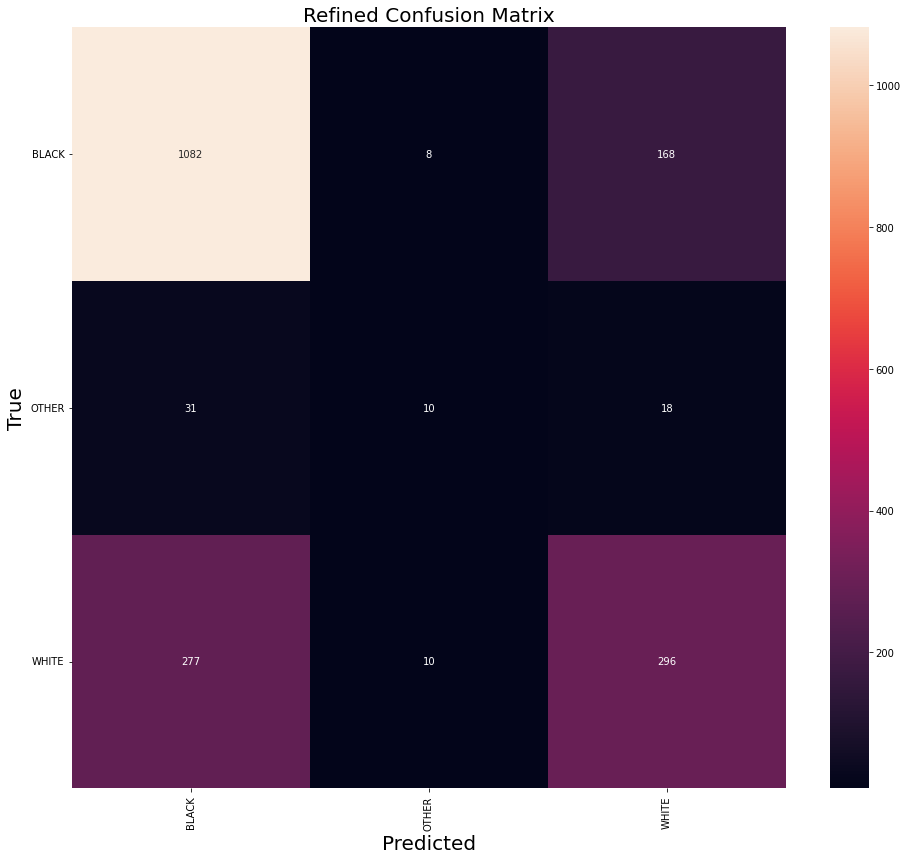

Macro F1-score on final test set : 0.53432471529295
The model predicts "Black" with 0.8172205438066465 accuracy, "Other" with 0.22988505747126434 accuracy and "White" with 0.5558685446009389 accuracy


In [4]:
df = pd.read_csv(os.path.join(data_path,'test_preprocessed.csv'))
alignement = pd.read_csv(os.path.join(data_path,'model_alignement.csv'), index_col=0) # Column df only for Model Alignement. No data leakage present from train to test. 

vars_to_keep = ['SUSPECT_HAIR_COLOR','SUSPECT_EYE_COLOR','STOP_LOCATION_BORO_NAME','SUSPECTED_CRIME_DESCRIPTION','FRISKED_FLAG','SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG','SUSPECT_ARREST_OFFENSE'	
,'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG','FIREARM_FLAG','SUSPECT_BODY_BUILD_TYPE','BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG'	
,'OTHER_WEAPON_FLAG','WEAPON_FOUND_FLAG','VERBAL_IDENTIFIES_OFFICER_FLAG','SUSPECTS_ACTIONS_CASING_FLAG','SUPERVISING_OFFICER_RANK','DEMEANOR_CODE','MONTH2'
,'OFFICER_IN_UNIFORM_FLAG','SUSPECT_ARRESTED_FLAG','STOP_LOCATION_ZIP_CODE','STOP_WAS_INITIATED','SEARCH_BASIS_HARD_OBJECT_FLAG','SEARCHED_FLAG','SUSPECT_SEX','OTHER_CONTRABAND_FLAG'	
,'SEARCH_BASIS_CONSENT_FLAG','IMMEDIATE_STOP_FLAG','STOP_DURATION_MINUTES','SUSPECT_REPORTED_AGE','SUSPECT_HEIGHT','SUSPECT_WEIGHT'          
,'KMEANS_DEMEANOR']

X,y = prepare_data(df, vars_to_keep, alignement)

final_model = pickle.load(open(os.path.join(model_path,'final_MLP.model'), 'rb'))

y_pred = final_model.predict(X)

print('Confusion matrix of the final test set')
multiclass_confusion(y_pred,y)

macro_f1 = f1_score(y, y_pred, average='macro')
print('Macro F1-score on final test set : {}'.format(macro_f1))

micro_f1 = f1_score(y, y_pred, average=None)
print('The model predicts "Black" with {} accuracy, "Other" with {} accuracy and "White" with {} accuracy'.format(micro_f1[0], micro_f1[1],micro_f1[2]))